# **TP05 - Máquina de vectores soporte (SVM)**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP05/imagenes/enunciado.png?raw=true" alt="enunciado TP5">
</p>


In [1]:
#librerias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from sklearn.preprocessing import LabelEncoder
import cvxopt
from matplotlib.lines import Line2D

In [2]:
# Cargamos el dataset 'geyser'
geyser = sns.load_dataset('geyser')

# Mostramos las primeras filas del dataset
print(geyser.head())

   duration  waiting   kind
0     3.600       79   long
1     1.800       54  short
2     3.333       74   long
3     2.283       62  short
4     4.533       85   long


## **SVM**

Una Máquina de Vectores de Soporte (SVM) es un algoritmo de clasificación supervisada que busca encontrar el hiperplano óptimo que separa dos clases de datos.

A diferencia de otros clasificadores, una SVM no solo busca separar las clases correctamente, sino que intenta hacerlo maximizando el margen, es decir, la distancia entre la frontera de decisión y los puntos más cercanos de cada clase.

Estos puntos más cercanos al hiperplano se llaman vectores soporte, y son los únicos que definen la solución final. Los puntos más alejados no influyen en la posición del hiperplano.

### Margen

El margen de una SVM se define como la distancia entre el hiperplano y las muestras más cercanas. Como criterio se toma el margen unilateral como:

$$
m(w, b) = \min_{1 \leq i \leq n} \frac{y_i(w^T x_i + b)}{\|w\|} = \frac{1}{\|w\|} \min_{1 \leq i \leq n} f_i(w, b)
$$

donde $ f_i(w, b) = y_i(w^T x_i + b) $.

El objetivo es **maximizar ese margen**, es decir:

$$
\max_{w,b} \; m(w, b) \quad \text{tal que } f_i(w, b) > 0 \quad \forall i
$$


### Escala

Se puede ver que la decisión $ z(x) = w^T x + b $ no se ve afectada si multiplicamos $ w $ y $ b $ por un parámetro $ \alpha > 0$, por lo tanto, la frontera de decisión tampoco se ve afectada por éste reescalamiento.

Entonces, no se pierde generalidad si se reescala $ w $ y $ b $ de manera tal que :

$$
f_k(w, b) = 1 \quad \text{(donde \( k \) es el índice de una muestra que toca el margen)}
$$

Con esto, podemos expresar el margen como:

$$
m(w, b) = \frac{1}{\|w\|}
$$

Y la condición de clasificación para todos los puntos se convierte en:

$$
y_i(w^T x_i + b) \geq 1 \quad \forall i
$$

---

### **SVM con hard margin**

Supongamos un conjunto de entrenamiento con muestras $ (x_i, y_i) $, donde:
- $ x_i \in \mathbb{R}^d $ es un vector de características,
- $ y_i \in \{-1, 1\} $ es la etiqueta de clase.

Queremos encontrar un hiperplano definido por un vector $ w $ y un sesgo $ b $ tal que:

$$
f(x) = w^T x + b
$$

Con esto podemos definir el problema de optimización primal: 

$$
\begin{aligned}
\min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 \quad \forall i
\end{aligned}
$$

Este es un problema de optimización cuadrática con restricciones lineales, ideal para resolver mediante programación cuadrática usando como herramienta `solve_qp`.

---

### **solve_qp**

`solve_qp` es una función de la librería `qpsolvers` que resuelve un problema de programación cuadrática (QP) de la forma estándar:

$$
\text{min} \quad \frac{1}{2} z^T P z + q^T z \quad (1)
$$

sujeto a:

$$
Gz \leq h
$$
$$
A z = b
$$

Donde:

- `z` es el vector de variables que queremos encontrar.
- `P` es una matriz simétrica y semidefinida positiva que define el término cuadrático de la función objetivo.
- `q` es el vector que define el término lineal de la función objetivo.
- `G` y `h` definen las restricciones de desigualdad.
- `A` y `b` definen las restricciones de igualdad.

Por lo tanto, para resolver el problema primal de una SVM, debemos definir estas matrices y vectores.

Partiendo del problema primal con hard-margin, queremos minimizar:

$$
\frac{1}{2} \|w\|^2 
$$

sujeto a:

$$
y_i(w^T x_i + b) \geq 1 
$$

Esto se traduce en:

- `P`: matriz que penaliza los términos cuadráticos (solo se aplica a `w`).
- `q`: vector nulo, ya que no hay penalización por variables de holgura.
- `G` y `h`: construyen las restricciones $ -y_i(w^T x_i + b) \leq -1 $.
- No se usan restricciones de igualdad en el primal, por lo que `A` y `b` no son necesarios.



---

### **Implementación**

Para poder implmentar el algoritmo de Máquina de Vectores Soporte, se creó una clase `SVM` que recibe como párametros `C` (hiperparametro de regularización que se explicará más adelante), `dual` que es un booleano que indica si queremos resolver el problema dual o no y `soft` que tambien es un booleano que indica si queremos utilizar soft o hard margins.


### **Etapa de entrenamiento**

Para entrenar la SVM, implementamos el método `fit` que recibe los datos de entrada `X` y las etiquetas `y`. Asumimos que las etiquetas de `y` son 0s o 1s, entonces lo primero que hacemos es modificar las etiquetas de manera tal que aquellas que pertenecían a la clase 0, ahora tengan un valor de -1, de esta forma, nos aseguramos que `y` solo tenga valores `-1` y `1`.

Luego en este caso que queremos implementar el problema primal, dentro de `fit` se llama al método `_fit_primal` pasando como argumentos `X` e `y`.


Dentro de `_fit_primal`, teniendo en cuenta el problema que resuelve `solve_qp` es:

$$
\left( \min \frac{1}{2} z^T P z + q^T z \quad \text{sujeto a:} \quad Gz \leq h,  A z = b  \right)
$$

y que el problema primal con hard margin es:

$$
\begin{aligned}
\min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 \quad \forall i
\end{aligned}
$$


  
Entonces, en este caso, el vector de variables de decisión $z$ es `[w₁, ..., w_n, b]`.  

Por lo tanto la matriz del término cuadrático $P$ debe ser la identidad en la parte correspondiente a $w$ y ceros en el resto.

En el caso del vector $q$, para hard-margin, dado que no hay término lineal, este vector es nulo.

En cuanto a $ G $ y $ h $, que representan las restricciones de desigualdad, debemos reformular la condición $ y_i(w^T x_i + b) \geq 1 $ para que encaje en la forma estándar $ Gz \leq h $ que espera el solver. Para lograrlo, multiplicamos por $-1$ a ambos lados, obteniendo $ -y_i(w^T x_i + b) \leq -1 $. La matriz $G$ en este caso tiene $n_{\text{samples}}$ filas y $n_{\text{features}}+1$ columnas.
Así, cada fila de $ G $ se construye colocando $-y_i x_i$ en las posiciones correspondientes a $ w $ y $-y_i$ en la posición correspondiente a $ b $. El vector $ h $ queda simplemente formado por $-1$ en todas sus componentes.


Como no tenemos restricciones de igualdad, no hace falta definir $A$ y $b$.

Una vez que definimos las matrices $P$, $q$, $G$ y $h$, utilizamos la función `solve_qp` con estos parámetros y configuramos el solver a utilizar como `solver='cvxopt'`. Con ésto obtenemos el vector de variables de decisión $z$, por lo tanto nos quedamos con los primeros n valores para definir $w$ y los demas son los valores de $b$.



### **Etapa de testeo**


Para la etapa de testeo se implementa la función `predict`, que recibe un vector de entradas `X` y en base a este devuelve la clase predicha con:

$$
\text{sign} \left( w^T X + b \right)
$$


Por último, la función `decision_function` se utiliza para calcular la distancia de cada punto en el plano de características con respecto a la recta de decisión de la SVM. Cuando se grafican los resultados, se utiliza esta función para generar el valor de la frontera de decisión en el plano de características, lo que permite trazar la recta que separa las clases. Además, se pueden visualizar los márgenes de la SVM al graficar las líneas correspondientes a los valores de -1 y 1, que corresponden a las fronteras de soporte de las clases.



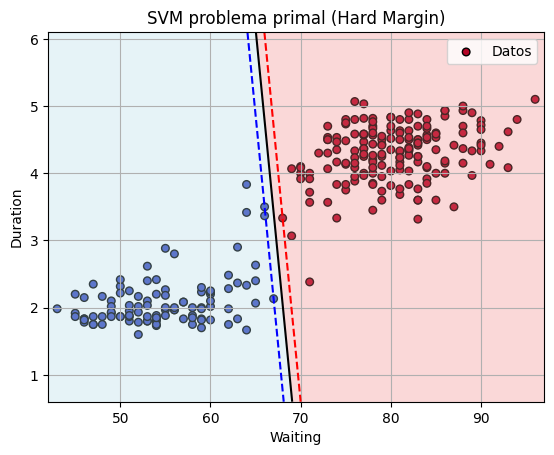

In [3]:
#clase SVM que implementa los problemas primal y dual, tanto para hard margin como para soft margin.
class SVM:
    def __init__(self, C=1.0, dual=False, soft=False):
        self.C = C #parámetro de regularización
        self.dual = dual #indica si se resuelve el problema dual o no
        self.soft = soft #indica si se quiere soft o hard margin

    #etapa de entrenamiento
    def fit(self, X, y):
        # transformamos las etiquetas a -1 y 1
        y = y.astype(np.float64)
        y[y == 0] = -1

        #se llama al método correspondiente
        if self.dual:
            self._fit_dual(X, y)
        else:
            self._fit_primal(X, y)

    def _fit_primal(self, X, y):
        n_samples, n_features = X.shape

        if self.soft:
            # Variables: [w (n_features), b, xi (n_samples)]

            #matriz P: identidad para las correspondientes a w, 0 para el resto
            P = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
            P[:n_features, :n_features] = np.eye(n_features)

            # vector q: C para las correspondientes a \xi, 0 para los demas
            q = np.zeros(n_features + 1 + n_samples)
            q[n_features + 1:] = self.C

            # Restricciones de desigualdad
            G = np.zeros((2 * n_samples, n_features + 1 + n_samples))  # Matriz G
            h = np.zeros(2 * n_samples)  # Vector h

            # Llenar las primeras n_samples filas de G
            G[:n_samples, :n_features] = -np.multiply(y[:, np.newaxis], X)  # -y_i * X_i para las correspondientes a w
            G[:n_samples, n_features] = -y  # -y_i para el término de b
            G[:n_samples, n_features + 1:] = -np.eye(n_samples)  # -1 para las variables \xi
            h[:n_samples] = -1  # -1 para las primeras n_samples

            # Llenar las siguientes n_samples filas de G
            G[n_samples:, n_features + 1:] = -np.eye(n_samples)  # -1 para las variables \xi
            h[n_samples:] = 0  # 0 para los siguientes n_samples

        else:  # hard-margin
            # Variables: [w (n_features), b]

            # matriz P: identidad en la parte w, 0 en las demas
            P = np.zeros((n_features + 1, n_features + 1))
            P[:n_features, :n_features] = np.eye(n_features)

            # q nulo
            q = np.zeros(n_features + 1)

            # restricciones de desigualdad
            G = np.zeros((n_samples, n_features + 1))
            h = -np.ones(n_samples)

            G[:n_samples, :n_features] = -np.multiply(y[:, np.newaxis], X)  # -y_i * X_i para las correspondientes a w
            G[:n_samples, n_features] = -y  # -y_i para el término de b

        #obtenemos la solucion
        solution = solve_qp(P, q, G, h, solver='cvxopt')
        self.w = solution[:n_features]
        self.b = solution[n_features]

    #problema dual
    def _fit_dual(self, X, y):
        n_samples, n_features = X.shape

        #matriz Q
        Q = np.outer(y, y) * (X @ X.T)

        P = Q
        q = -np.ones(n_samples)

        #matrices de igualdad
        A = y.reshape(1, -1)
        b = np.array([0.])


        #matrices de desigualdad
        if self.soft:
            G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
            h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C])
        else:  # hard-margin
            G = -np.eye(n_samples)
            h = np.zeros(n_samples)

        # obtenemos los alphas
        alpha = solve_qp(P, q, G, h, A, b, solver='cvxopt')

        # obtenemos los vectores soporte
        self.alpha = alpha
        self.support_ = alpha > 1e-5
        self.X_sv = X[self.support_]
        self.y_sv = y[self.support_]
        self.alpha_sv = alpha[self.support_]

        # obtenemos w y b
        self.w = (self.alpha_sv * self.y_sv) @ self.X_sv
        self.b = np.mean(self.y_sv - self.X_sv @ self.w)

    # etapa de testeo
    def predict(self, X):
        return np.sign(X @ self.w + self.b)
    
    def decision_function(self, X):
        return X @ self.w + self.b
    

# funcion para graficar
def plot_svm(model, X, y, title='SVM', ax=None):
    # Si no se pasa un `ax`, se crea uno nuevo
    if ax is None:
        ax = plt.gca()

    # Scatter de datos
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

    # Frontera de decisión
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid).reshape(xx.shape)

    # Pintar las regiones
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], colors=['lightblue', 'lightcoral'], alpha=0.3)

    # Dibujar frontera y márgenes
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--', '-', '--'])

    ax.set_xlabel('Waiting')
    ax.set_ylabel('Duration')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)


# separamos los datos de entrada y las etiquetas
X = geyser[['waiting', 'duration']].values

# obtenemos las etiquetas
y = (geyser['kind'] == 'long').astype(int).values

# Creamos el modelo
model_primal = SVM()
model_primal.fit(X, y)

# ------------------ GRAFICAR -------------------
plot_svm(model_primal, X, y, title="SVM problema primal (Hard Margin)")


Se observa en el gráfico:
- Con puntos rojos, aquellas muestras que están clasificadas como `long` (de larga duración).
- Con puntos azules, aquellas muestras que están clasificadas como `short` (de corta duración).

- Las clases no tienen superposición, lo que es ideal para SVM con Hard Margin dado que el problema es linealmente separable.
- La frontera de decisión (línea negra) está ubicada de forma equidistante respecto a los grupos de datos.

- Las líneas punteadas son las rectas de vectores soporte.
- Las muestras que están sobre las rectas punteadas son los vectores soporte, fundamentales para definir la posición de la frontera.


---

### **SVM dual con Hard Margin**

Queremos resolver el problema dual de la SVM, para ello partimos del problema primal que se define:

$$
\begin{aligned}
J_1 = \min_{w, b} \quad & \frac{1}{2} \|w\|^2 \\
\text{sujeto a} \quad & y_i(w^T \phi(x_i) + b) \geq 1 \quad \forall i
\end{aligned}
$$

Donde $ \phi(x_i) $ representa el mapeo de los datos a un espacio de características (por ejemplo, a través de un kernel).

Estem problema se puede reescribir utilizando multiplicadores de Lagrange $ \alpha_i \geq 0 $: 

$$
J_1 = \min_{w, b} \max_{\alpha_i \geq 0}  \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i \left[ y_i(w^T \phi(x_i) + b) - 1 \right]
$$

Queremos ahora encontrar el dual, resolviendo:

$$
J_2 = \max_{\alpha_i \geq 0} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i \left[ y_i(w^T \phi(x_i) + b) - 1 \right]
$$

Desarrollando:


$$
J_2 = \max_{\alpha_i \geq 0} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i y_i w^T \phi(x_i) - \sum_{i=1}^n \alpha_i y_i b + \sum_{i=1}^n \alpha_i
$$


Calculamos las derivadas parciales para minimizar respecto a $ w $ y $ b $:

- Derivada respecto a $ w $:

$$
\frac{\partial J_2}{\partial w} = w - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0
\Rightarrow \boxed{w = \sum_{i=1}^n \alpha_i y_i \phi(x_i)}
$$

- Derivada respecto a $ b $:

$$
\frac{\partial J_2}{\partial b} = -\sum_{i=1}^n \alpha_i y_i = 0
\Rightarrow \boxed{\sum_{i=1}^n \alpha_i y_i = 0}
$$


Sustituimos $ w $ y $ b $ en $ J_2 $, y obtenemos:

$$
J_2 = \frac{1}{2} \|w\|^2 - \sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) + \sum_{i=1}^n \alpha_i
$$

- El término con $ b $ desaparece porque $ \sum \alpha_i y_i = 0 $
- $\sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) = w^T \sum_{i=1}^n \alpha_i y_i \phi(x_i) = w^T w = \| w\|^2$

Por lo que reescribiendo, llegamos a que:

$$
J_2 = \max_{\alpha_i} \sum_{i=1}^n \alpha_i - \| w \|^2
$$

$\| w \|^2$ se convierte en una suma doble utilizando el resultado de $w$:

$$
\begin{aligned}
\|w\|^2 &= \left\| \sum_{i=1}^n \alpha_i y_i \phi(x_i) \right\|^2 \\
&= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \phi(x_i)^T \phi(x_j)
\end{aligned}
$$

Con esto podemos definir la **matriz $ Q $** como:

$$
Q_{ij} = y_i y_j \phi(x_i)^T \phi(x_j)
$$

Por lo tanto, podemos escribir la norma como:

$$
\|w\|^2 = \alpha^T Q \alpha
$$


Con todo ésto se obtiene finalmente el problema **dual** como:

$$
\begin{aligned}
\max_{\alpha} \quad & \mathbf{1}^T \alpha - \frac{1}{2} \alpha^T Q \alpha \\
\text{sujeto a} \quad & \alpha^T y = 0 \\
& \alpha_i \geq 0 \quad \forall i
\end{aligned}
$$

Este problema cuadrático se puede resolver usando técnicas de **programación cuadrática (QP)**.

El sesgo $ b $, en el problema dual, se puede estimar de la siguiente forma:

$$
b = \frac{1}{N_S} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j \in \mathcal{S}} \alpha_j y_j \phi(x_j)^T \phi(x_i) \right)
$$

donde $\mathcal{S}$ es el conjunto de índices de vectores soporte y $N_s$ la cantidad de elementos de dicho conjunto.


---

### **Implementación**

Para poder resolver el problema dual con hard margin, utilizamos la clase `SVM` con los parámetros `dual = True` y `soft = False`.  

### **Etapa de Entrenamiento**

Al igual que en el caso primal, para entrenar la SVM en su forma dual, se utiliza el método `fit`. Este método recibe los datos de entrada `X` y las etiquetas `y`. En primer lugar, las etiquetas se modifican de modo que aquellas que son 0 se convierten en -1.

Dentro del método `fit` se llama al método `_fit_dual` con los datos de entrada `X` e `y`.

Dentro de `_fit_dual`, el problema cuadrático que se resuelve es el siguiente:

$$
\max_{\alpha} \frac{1}{2} \alpha^T Q \alpha - \mathbf{1}^T \alpha
$$

Sujeto a las restricciones:

$$
y^T \alpha = 0 \quad \text{y} \quad 0 \leq \alpha_i \quad \forall i
$$

Del desarrollo anterior obtuvimos unaa expresion para la matriz $Q$. Para nuestro problema tomamos $\phi(x) = x$, por lo tanto la matriz se calcula como:


$$
Q_{ij} = y_i y_j x_i x_j^T
$$

Luego, para seguir con la notación utilizada en `solve_qp`, $P = Q$


Luego, $ q $ es un vector de unos negativos:

$
q = -\mathbf{1}
$

Esto se debe a que estamos maximizando la función objetivo en el problema dual.

Las restricciones son dos:
1. La restricción de igualdad $ y^T \alpha = 0 $, que garantiza que la suma ponderada de los multiplicadores de Lagrange sea cero. Esta restricción se define mediante la matriz $ A = y $ y el vector $ b = 0 $.
2. La restriccion de desigualdad $ \alpha_i \geq 0 $, que se representan con la matriz $ G $ y el vector $ h $. Por lo tanto para llevarlo a la forma que espera `solve_qp`, la restricción de desigualdad será $-\alpha_i \leq 0$, por lo tanto la matriz $G = -I$ donde $I$ es la matriz identidad, y $h$ será un vector de ceros.

Con las matrices $ P $, $ q $, $ G $, y $ h $, utilizamos la función `solve_qp` del solver `cvxopt` para resolver el problema cuadrático. Este solver encuentra el vector $ \alpha $ que maximiza la función objetivo bajo las restricciones impuestas.

Los multiplicadores $ \alpha_i $ determinan los vectores soporte. Aquellos índices $ i $ en los que $ \alpha_i $ es mayor que un umbral pequeño (se tomó $ 1e-5 $ como umbral) se consideran vectores soporte. Estos vectores son almacenados en `self.X_sv` y `self.y_sv`, junto con sus correspondientes valores $ \alpha_i $ en `self.alpha_sv`.

El vector de pesos $ w $ se calcula con los vectores soporte como:

$$
w = \sum_{i} \alpha_{i} y_{i} x_{i}
$$

Este vector define el hiperplano de separación en el espacio de características.

Finalmente, el valor del sesgo $ b $ se estima tomando el promedio de las diferencias entre las etiquetas de los vectores soporte y su proyección en el hiperplano:

$$
b = \frac{1}{N_S} \sum_{i \in \mathcal{S}} \left( y_i - w^T x_i \right)
$$

Donde $ N_S $ es el número de vectores soporte.

### **Etapa de Testeo**

Al igual que en el caso primal, para la etapa de testeo se implementa la función `predict`. Dado un nuevo conjunto de entradas $ X $, la predicción se realiza utilizando la función de decisión:

$$
\hat{y} = \text{sign}(w^T X + b)
$$

Este método devuelve $ +1 $ o $ -1 $ según el signo de la expresión $ w^T X + b $, lo que indica a qué clase pertenece el punto $ X $.



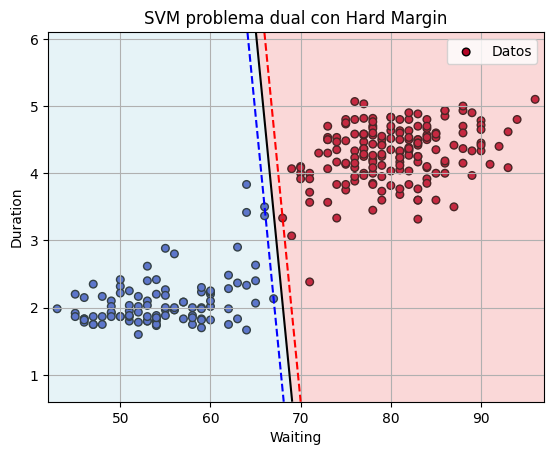

In [ ]:

# Creamos el modelo y entrenamos
model_dual = SVM(soft=False, dual=True)
model_dual.fit(X, y)


# grafico
plot_svm(model_dual, X, y, title="SVM problema dual con Hard Margin")


--- 

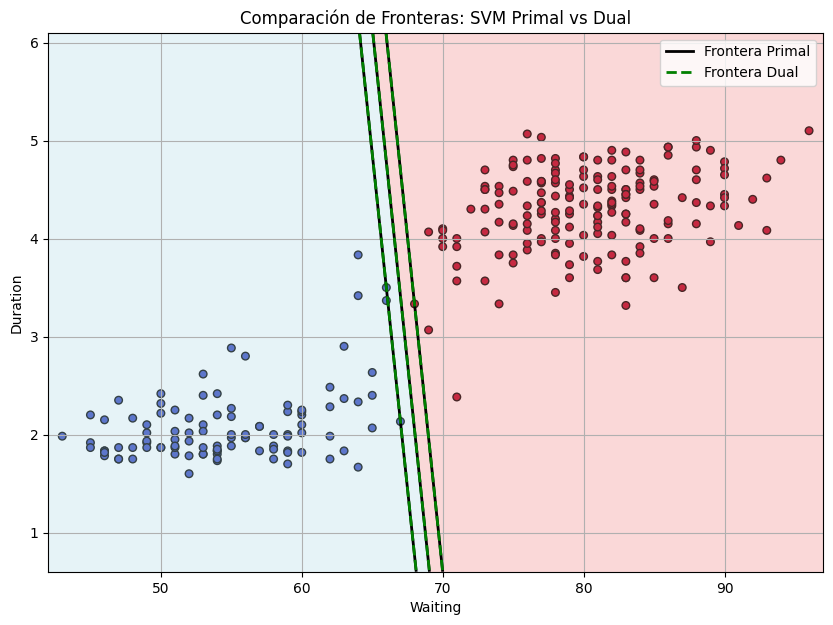

In [5]:
# gráfico de comparación
plt.figure(figsize=(10, 7))

# Scatter de los puntos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k', label='Datos')

# Malla para evaluar
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# Fronteras
Z_primal = model_primal.decision_function(grid).reshape(xx.shape)
Z_dual = model_dual.decision_function(grid).reshape(xx.shape)

# Pintar regiones usando el modelo primal
plt.contourf(xx, yy, Z_primal, levels=[-np.inf, 0, np.inf], colors=['lightblue', 'lightcoral'], alpha=0.3)

# Graficar fronteras
plt.contour(xx, yy, Z_primal, levels=[-1, 0, 1], colors='black', linestyles='-', linewidths=2)
plt.contour(xx, yy, Z_dual, levels=[-1, 0, 1], colors='green', linestyles='--', linewidths=2)

# Crear leyenda manual con Line2D
legend_lines = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Frontera Primal'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Frontera Dual')
]

plt.legend(handles=legend_lines)
plt.xlabel('Waiting')
plt.ylabel('Duration')
plt.title('Comparación de Fronteras: SVM Primal vs Dual')
plt.grid(True)
plt.show()



Acá hice el gráfico solo para comparar que efectivamente el problema primal y dual con Hard Margin llegan al mismo resultado.

---

### **SVM primal con soft margin**

Muchas veces los datos no son perfectamente separables. Para manejar esta situación, se introduce el concepto de márgenes relajados, que permite ciertos errores de clasificación usando variables de holgura $ \xi_i \geq 0 $.

Estas variables permiten que algunas muestras:
- Estén dentro del margen.
- Sean clasificadas incorrectamente.

El nuevo problema primal se define como:

$$
\begin{aligned}
\min_{w, b, \xi} \quad & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{tal que} \quad & y_i(w^T x_i + b) \geq 1 - \xi_i \quad \forall i \\
& \xi_i \geq 0 \quad \forall i
\end{aligned}
$$

Donde:
- $ \xi_i $ indica cuánto se aleja la muestra $ i $ del margen esperado.
- $ C > 0 $ es un **hiperparámetro** que controla el trade-off entre:
  - Maximizar el margen (minimizar $ \|w\|^2 $).
  - Penalizar errores (minimizar $ \sum \xi_i $).


- Si $ C $ es **grande**, se penalizan mucho los errores, es decir, se busca que casi todos los puntos estén bien clasificados (parecido al hard margin).
- Si $ C $ es **pequeño**, se permite mayor flexibilidad, es decir, más tolerancia a errores o ruido.

Esto transforma el problema en una **optimización cuadrática convexa con restricciones lineales**, y se puede seguir resolviendo con programación cuadrática (`solve_qp`), agregando las variables de holgura $ \xi $.


---


### **Implementación**

Si queremos resolver el problema primal con soft margins debemos utilizar la clase `SVM` con los parámetros `dual = False`, `soft = True` y debemos especificar el valor del hiperparámetro `C`. Si no se modifica, por default `C = 1`.

### **Etapa de Entrenamiento**

En el método `fit`, primero se ajustan las etiquetas para que las clases 0 se conviertan en -1 y se llama a `_fit_primal`.

En el caso de un problema primal con soft margin, se optimiza la función de costo definida por:

$$
\min_{w, b, \xi} \quad \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i
$$

Sujeta a las restricciones:

$$
y_i(w^T x_i + b) \geq 1 - \xi_i \quad \forall i, \quad \xi_i \geq 0 \quad \forall i
$$


Dado que el vector de variables de decisión es $ z = [w_1, \dots, w_n, b, \xi_1, \dots, \xi_n] $, la matriz $ P $ se construye como una matriz cuadrada de tamaño $ n_{\text{features}} + 1 + n_{\text{samples}} $, donde:
- La parte correspondiente a $ w $ se llena con la identidad $ I $, ya que el término cuadrático en la función objetivo es $ \frac{1}{2} \|w\|^2 $.
- El resto de la matriz se llena con ceros.

El vector $ q $ se ajusta para incluir las penalizaciones asociadas con las variables de holgura $ \xi_i $, multiplicadas por el hiperparámetro de regularización $ C $. Así, las primeras $ n_{\text{features}} + 1 $ posiciones de $ q $ se mantienen en cero, mientras que las últimas $ n_{\text{samples}} $ posiciones son iguales a $ C $.

La restricciones de desigualdad, para llevarlo a la forma que espera el solver, se pueden reescribir de la siguiente manera:

$$
-y_i(w^T x_i + b) - \xi_i \leq -1 \quad \forall i, \quad -\xi_i \leq 0 \quad \forall i
$$

La matriz $G$ tiene $2 \times n_{\text{samples}}$ filas y $n_{\text{features}} + 1 + n_{\text{samples}}$ columnas.

De esta forma, las restricciones $ Gz \leq h $ se construyen de acuerdo con las condiciones impuestas por las variables de holgura y el margen. En primer lugar:
- Las primeras $ n_{\text{samples}} $ filas de $ G $ representan la condición $ -y_i(w^T x_i + b) - \xi_i \leq 1$. Estas filas se llenan de manera que:
  - La parte correspondiente a $ w $ se llena con $ -y_i x_i $,
  - La parte correspondiente a $ b $ se llena con $ -y_i $,
  - La parte correspondiente a $ \xi_i $ se llena con $ -1 $.
  
  De esta forma, cada restricción asegura que las muestras estén separadas por el margen y que las variables $ \xi_i $ sean mayores o iguales a cero.

- Las siguientes $ n_{\text{samples}} $ filas de $ G $ aseguran que $ -\xi_i \leq 0 $. Estas filas se llenan con $ -1 $ en las posiciones correspondientes a las variables de holgura $ \xi_i $.

Finalmente, el vector $ h $ se llena con los valores correspondientes:
- Las primeras $ n_{\text{samples}} $ posiciones de $ h $ son igual a $ -1 $, para la condición $ y_i(w^T x_i + b) \geq 1 - \xi_i $.
- Las siguientes $ n_{\text{samples}} $ posiciones son igual a $ 0 $, para la condición $ \xi_i \geq 0 $.

Una vez definidas las matrices $ P $, $ q $, $ G $ y $ h $, se utiliza la función `solve_qp` con estos parámetros, configurando el solver como `solver='cvxopt'`. El resultado es el vector de variables de decisión $ z $, del cual los primeros $ n_{\text{features}} $ valores corresponden a $ w $, el siguiente valor corresponde a $ b $, y los últimos $ n_{\text{samples}} $ valores corresponden a las variables $ \xi_i $.


### **Etapa de Testeo**

En la etapa de testeo, la función `predict` recibe un nuevo conjunto de datos $ X $ y devuelve las predicciones utilizando la función de decisión:

$$
\hat{y} = \text{sign}(w^T X + b)
$$


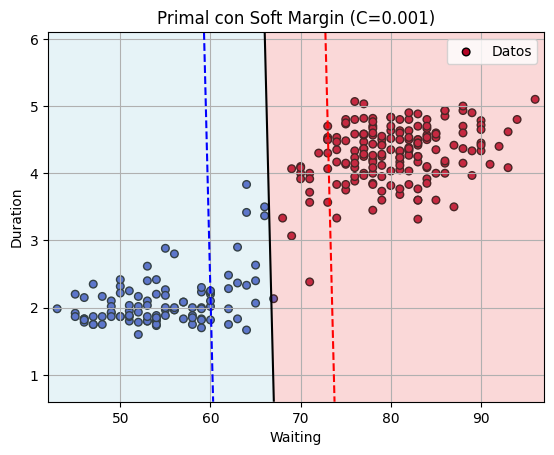

In [ ]:
# Entrenamos los modelos SVM (primal) con distintos valores de C

model_primal_C01 = SVM(C=0.1, soft=True,dual=False)
model_primal_C01.fit(X, y)

model_primal_C001 = SVM(C=0.001, soft=True,dual=False)
model_primal_C001.fit(X, y)

#grafico con C=0.001 para ver que se esté implementando bien los márgenes relajados
plot_svm(model_primal_C001, X, y, title="Primal con Soft Margin (C=0.001)")



Efectivamente se observa que los margenes son más grandes, ademas una de las muestras de color azul queda en la región asociada a las muestras clasificadas como `long`, por lo tanto, se puede observar que al relajar los margenes puede haber errores en la clasificación.

---

### **SVM dual con Soft Margin**

En el caso de soft-margin, permitimos errores en la clasificación mediante **variables de holgura** $ \xi_i \geq 0 $. El objetivo es encontrar un equilibrio entre maximizar el margen y minimizar el error, controlado por un hiperparámetro $ C $.

Partimos del problema primal:

$$
\begin{aligned}
J_1 = \min_{w, b, \xi} \quad & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{sujeto a} \quad & y_i(w^T \phi(x_i) + b) \geq 1 - \xi_i \\
& \xi_i \geq 0 \quad \forall i
\end{aligned}
$$


Introducimos los multiplicadores de Lagrange:

- $ \alpha_i \geq 0 $ para $ y_i(w^T \phi(x_i) + b) \geq 1 - \xi_i $
- $ \mu_i \geq 0 $ para $ \xi_i \geq 0 $

Entonces queda de la siguiente manera:

$$
J_1 = \min_{w, b} \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \xi_i - \sum_{i=1}^{n} \alpha_i [y_i(w^T \phi(x_i) + b) - 1 + \xi_i] - \sum_{i=1}^{n} \mu_i \xi_i
$$

Agrupando términos:

$$
J_1 = \min_{w, b} \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i w^T \phi(x_i) - b \sum_{i=1}^{n} \alpha_i y_i + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - \mu_i)
$$

Por lo tanto, el problema dual con soft margins queda:

$$
J_2 = \max_{\substack{\alpha_i \geq 0 \\ \mu_i \geq 0}} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i w^T \phi(x_i) - b \sum_{i=1}^{n} \alpha_i y_i + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - \mu_i)
$$


Para poder minimizar con respecto a $w$ y $b$ calculamos las derivadas parciales:

1. Derivada respecto a $ w $:

$$
\frac{\partial J_2}{\partial w} = w - \sum_{i=1}^n \alpha_i y_i \phi(x_i) = 0 \Rightarrow \boxed{w = \sum_{i=1}^n \alpha_i y_i \phi(x_i)}
$$

2. Derivada respecto a $ b $:

$$
\frac{\partial J_2}{\partial b} = -\sum_{i=1}^n \alpha_i y_i = 0 \Rightarrow \boxed{\sum_{i=1}^n \alpha_i y_i = 0}
$$

3. Derivada respecto a $ \xi_i $:

$$
\frac{\partial J_2}{\partial \xi_i} = C - \alpha_i - \mu_i = 0 \Rightarrow \boxed{\mu_i = C - \alpha_i}
$$

De ésta última, como sabemos que $\mu_i \geq 0$ (del mismo modo $\alpha_i \geq 0$ y $C > 0$), entonces se llega a que:

$$
\Rightarrow \boxed{0 \leq \alpha_i \leq C}
$$


Reemplazamos todas éstas expresiones encontradas en $J_2$:

$$
J_2 = \max_{\substack{0 \leq \alpha_i \leq C}} \min_{w, b} \frac{1}{2} \|w\|^2 - \sum_{i=1}^{n} \alpha_i y_i \phi(x_i)^T w + \sum_{i=1}^{n} \alpha_i + \sum_{i=1}^{n} \xi_i (C - \alpha_i - (C - \alpha_i))
$$

- El término con $ b $ desaparece porque $ \sum \alpha_i y_i = 0 $
- $\sum_{i=1}^n \alpha_i y_i (w^T \phi(x_i)) = w^T \sum_{i=1}^n \alpha_i y_i \phi(x_i) = w^T w = \| w\|^2$
- El último término tambien se anula.

Por lo tanto, reescribiendo:


$$
J_2 = \max_{0 \leq \alpha_i \leq C} \sum_{i=1}^n \alpha_i - \| w \|^2
$$

$\| w \|^2$ se convierte en una suma doble utilizando el resultado de $w$:

$$
\begin{aligned}
\|w\|^2 &= \left\| \sum_{i=1}^n \alpha_i y_i \phi(x_i) \right\|^2 \\
&= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \phi(x_i)^T \phi(x_j)
\end{aligned}
$$

Con esto podemos definir la **matriz $ Q $** como:

$$
Q_{ij} = y_i y_j \phi(x_i)^T \phi(x_j)
$$

Por lo tanto, podemos escribir la norma como:

$$
\|w\|^2 = \alpha^T Q \alpha
$$

Entonces el problema dual soft-margin queda:

$$
\begin{aligned}
\max_{\alpha} \quad & \mathbf{1}^T \alpha - \frac{1}{2} \alpha^T Q \alpha \\
\text{sujeto a} \quad & \alpha^T y = 0 \\
& 0 \leq \alpha_i \leq C \quad \forall i
\end{aligned}
$$

Basicamente la expresión es igual a la del problema dual con hard margins, pero ahora $\alpha$ tiene a $C$ como cota superior.

El sesgo $ b $, en el problema dual, se puede estimar de la siguiente forma:

$$
b = \frac{1}{N_S} \sum_{i \in \mathcal{S}} \left( y_i - \sum_{j \in \mathcal{S}} \alpha_j y_j \phi(x_j)^T \phi(x_i) \right)
$$

donde $\mathcal{S}$ es el conjunto de índices de vectores soporte y $N_s$ la cantidad de elementos de dicho conjunto.



---

### **Implementación**

Para resolver el problema dual con soft margins, se utiliza la clase `SVM` con los parámetros `dual=True`, `soft=True` y especificando el valor de $ C $. Por defecto, si no se indica, $ C=1 $.

### **Etapa de entrenamiento**

En la etapa de entrenamiento, dentro del método `fit`, se ajustan las etiquetas para que las clases $ 0 $ se conviertan en $ -1 $, y se llama a `_fit_dual`.


En el método `_fit_dual`, el problema se lleva a la forma que espera el solver:

- Como en el caso del problema dual con hard margin, la matriz $P$ se obtiene como: $P = Q_{ij} = y_i y_j x_i x_j^T$

- El vector $ q $: es un vector de $-1$ en todas sus entradas.

- La matriz $ G $ y vector $ h $: representan las restricciones $ 0 \leq \alpha_i \leq C $. La matriz $G$ tiene $2 \times n_{\text{samples}}$ filas y $n_{\text{samples}}$ columnas:
  - Las primeras $n_{\text{samples}}$ filas imponen la restricción $ \alpha_i \geq 0 $, si lo llevamos a la forma que espera el solver sería $-\alpha_i \leq 0$, para ello se usa un primer bloque  $ G_1 = -I $, $ h_1 = 0 $.
  - Las siguientes $n_{\text{samples}}$ imponen la restricción $ \alpha_i \leq C $, para ello se usa un segundo bloque $ G_2 = I $, $ h_2 = C $.
  - Finalmente, $ G $ se construye concatenando $ G_1 $ y $ G_2 $, y $ h $ concatenando $ h_1 $ y $ h_2 $.
- La matriz $ A $ y el vector $ b $: representan la restricción de igualdad $ \sum_i \alpha_i y_i = 0 $. Para esto se definen la matriz de la siguiente manera: $A = y$ y $b$ un vector de ceros.

Estas matrices y vectores son pasados a `solve_qp` usando `solver='cvxopt'`.

Una vez que se obtienen los valores óptimos de $ \alpha $, se calculan:

- El vector de pesos $ w $, a partir de los vectores soporte, como:

$$
w = \sum_{i=1}^n \alpha_i y_i x_i
$$

- El sesgo $ b $ como un promedio sobre los vectores de soporte, utilizando la fórmula mencionada anteriormente.

---

### **Etapa de Testeo**

En la etapa de testeo, la función `predict` usa la función de decisión:

$$
\hat{y} = \text{sign}(w^T x + b)
$$

para clasificar nuevos ejemplos.



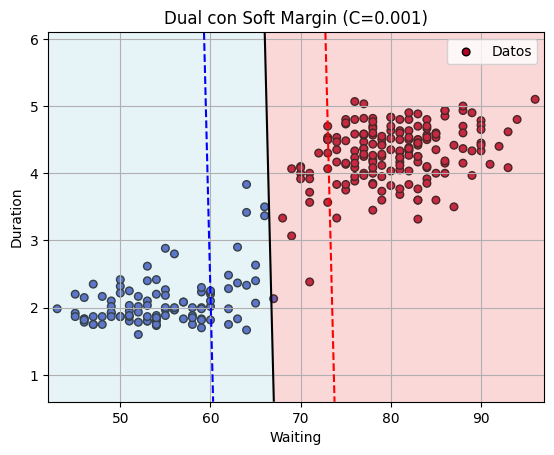

In [ ]:
# Entrenamos modelos SVM (dual) con distintos valores de C
model_dual_C01 = SVM(C=0.1, dual=True, soft = True)
model_dual_C01.fit(X, y)

model_dual_C001 = SVM(C=0.001, dual=True, soft = True)
model_dual_C001.fit(X, y)

#grafico dual con C=0.001 
plot_svm(model_primal_C001, X, y, title="Dual con Soft Margin (C=0.001)")

---

## **Gráfico de comparación**

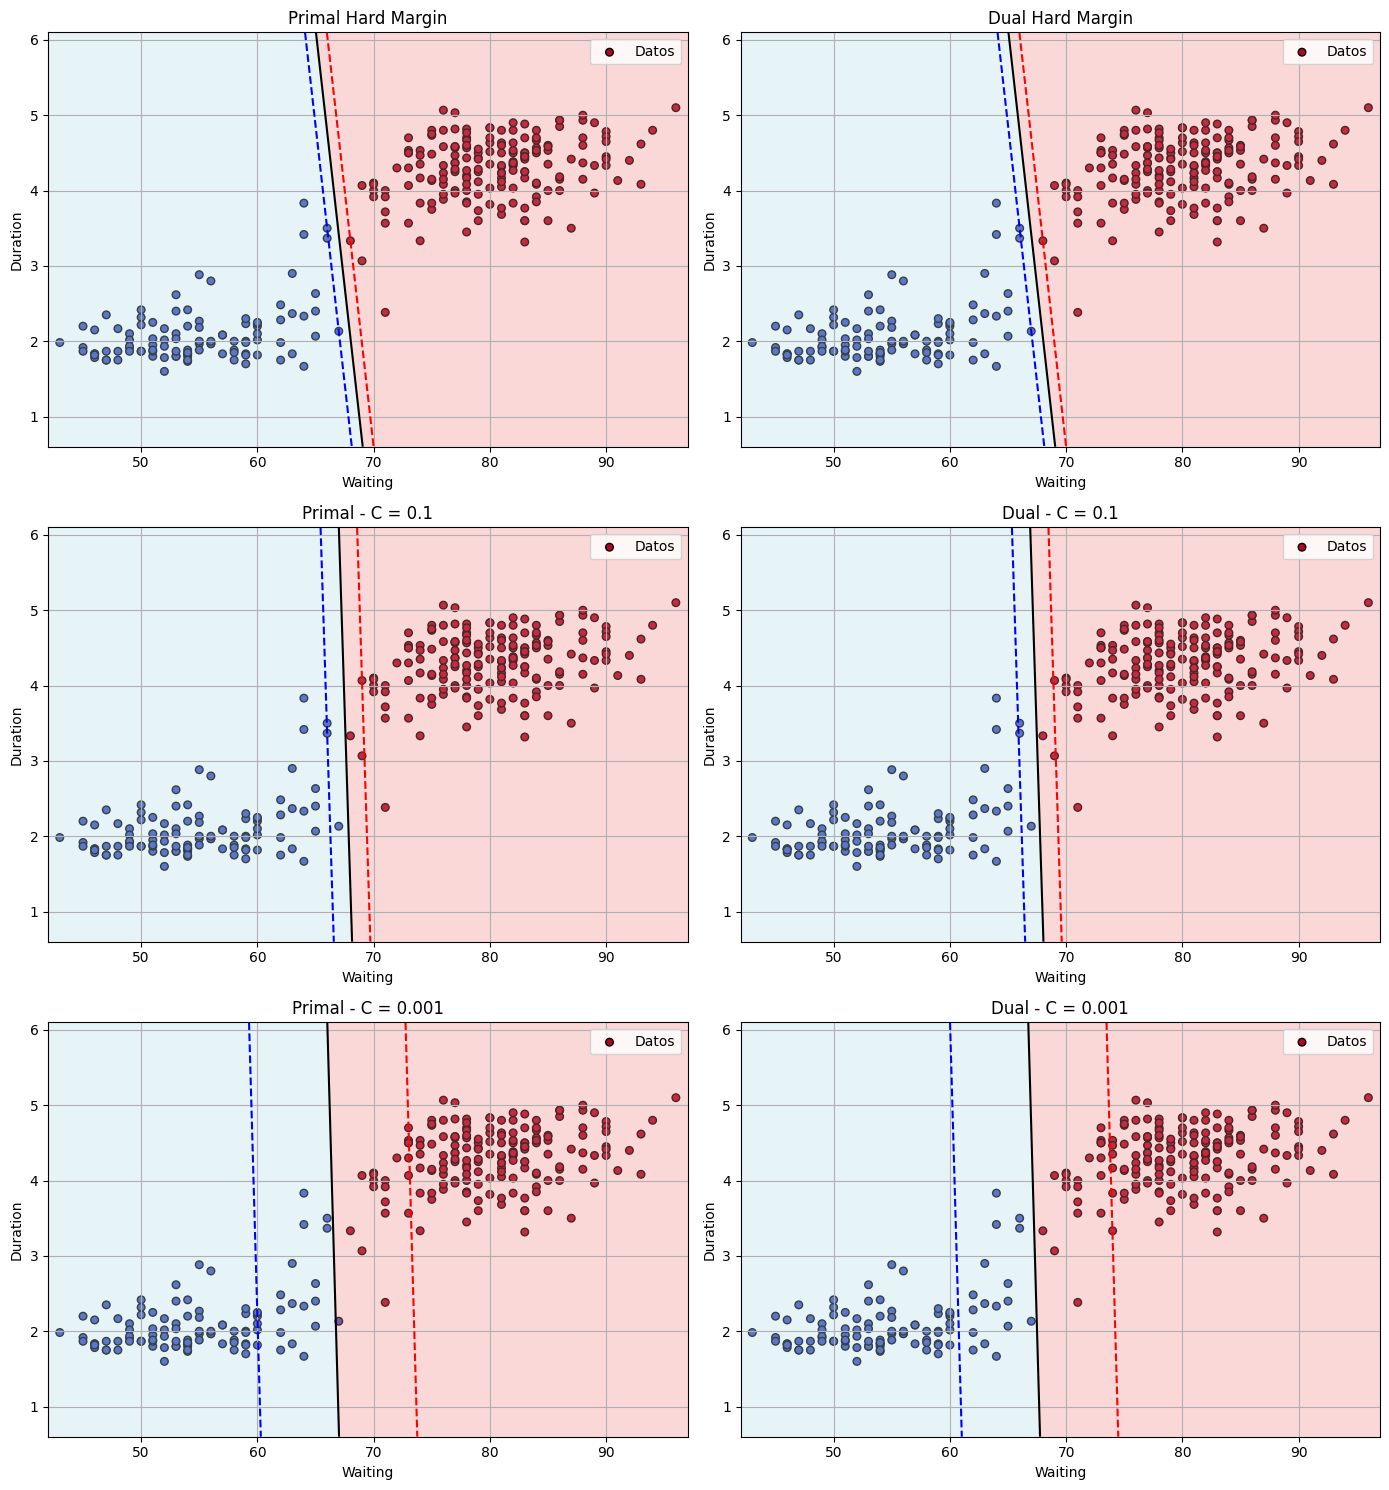

In [8]:

# Crear figura con subgráficos
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# primal vs dual hard margin
plot_svm(model_primal, X, y, title="Primal Hard Margin", ax=axes[0, 0])
plot_svm(model_dual, X, y, title="Dual Hard Margin", ax=axes[0, 1])

# primal vs dual C = 0.1
plot_svm(model_primal_C01, X, y, title="Primal - C = 0.1", ax=axes[1, 0])
plot_svm(model_dual_C01, X, y, title="Dual - C = 0.1", ax=axes[1, 1])

# primal vs dual C=0.001
plot_svm(model_primal_C001, X, y, title="Primal - C = 0.001", ax=axes[2, 0])
plot_svm(model_dual_C001, X, y, title="Dual - C = 0.001", ax=axes[2, 1])

# Ajustar los subgráficos para que no se superpongan
plt.tight_layout()
plt.show()




# Conclusiones SVM Primal vs Dual

## 1. Hard Margin
- La separación entre clases es perfecta. Esto se debe a que el problema es linealmente separable tal como se mencionó antes.
- Las fronteras obtenidas por el enfoque primal y dual son prácticamente idénticas.
- No hay errores de clasificación.

## 2. Soft Margin con C = 0.1
- Si bien ahora tenemos margenes relajados, se observa que todavía no hay errores de clasificación.
- El margen se amplía ligeramente para permitir cierta flexibilidad. se pueden observar que algunas muestras quedan en la zona entre frontera de decisión (linea negra) y los márgenes (lineas punteadas)
- Las fronteras primal y dual siguen siendo muy similares.

## 3. Soft Margin con C = 0.001
- El margen crece considerablemente.
- Se observa que hay errores errores de clasificación. En el caso del problema primal, hay una muestra azul (`short`) que queda clasificada como roja (`long`). En el caso del problema dual no hay errores de clasificación para dicho valor de `C`.
- Se observa que hay una mayor cantidad de muestras en la zona entre la frontera de decisión y los márgenes.
- Se observan mayores diferencias entre los enfoques primal y dual:
  - En el problema primal, algunas muestras están apoyadas exactamente sobre las rectas de margen.
  - En el problema dual, en particular para el margen azul, no se observan muestras apoyadas directamente sobre la recta.
- A pesar de estas diferencias, ambos modelos mantienen un comportamiento general comparable.


